In [144]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
from mesa.space import MultiGrid
import numpy as np
from mesa.datacollection import DataCollector
from operator import attrgetter

N_driver = 1000
N_passenger = 5000

In [145]:
class PassengerModel(Agent):
    def __init__(self,unique_id, model):
        super().__init__(unique_id, model)
        self.got_cab = 0
        self.distance = 0
        self.ask_price = 10
        self.state = 1 # 0, not looking for cab; 1 1ooking for; 2 on a cab
        self.start_journey = 0
        self.cost = 0
        self.journeys_time = 0
        
    def step(self):
        if self.state == 1:
            # Group 1: physically search by moving more distance
            if self.unique_id <= N_passenger/2:
                self.move()
            else:
                if self.ask_price <= 15:
                    self.ask_price += 1                  
        else:
            self.drop_off()
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True,include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def drop_off(self):
        if self.state == 2:
            if self.model.time - self.start_journey >= 10:
                self.state = 1
                self.cost += self.ask_price
                self.journeys_time += 1
                self.ask_price = 10
                


In [146]:
class DriverModel(Agent):
    def __init__(self,unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 0
        self.state = 0   # 0: idle ; -1: occupied
        self.start_journey = 0
        self.jobs_time = 0
    
    def step(self):
        if self.state == 0:
            self.find_passenger()
        else:
            self.drop_off_passenger()
            
            
    def find_passenger(self):
        gridmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(gridmates) > 1:
            passenger_list = [p for p in gridmates if p.unique_id <= N_passenger and p.state == 1]
            if len(passenger_list) >= 1:
                selected_passenger = max(passenger_list, key=attrgetter('ask_price'))
                self.wealth += selected_passenger.ask_price
                self.state = -1
                selected_passenger.state = 2
                selected_passenger.start_journey = self.model.time
                self.start_journey = self.model.time
        
    def drop_off_passenger(self):
        if self.model.time - self.start_journey >= 10:
            self.state = 0
            self.jobs_time += 1
        
            

In [147]:
[i for i in range(100, 105)]

[100, 101, 102, 103, 104]

In [148]:
class GrabModel(Model):
    def __init__(self, width, height, N_driver, N_passenger):
        self.num_drivers = N_driver
        self.num_passenger = N_passenger
        self.grid = MultiGrid(width, height,True)
        self.schedule = RandomActivation(self)
        self.time = 0
        
        for i in range(self.num_passenger):
            a = PassengerModel(i, self)          
            self.schedule.add(a)
            
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y))
            
        for i in range(self.num_passenger, self.num_passenger+self.num_drivers):
            a = DriverModel(i,self)          
            self.schedule.add(a)
            
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y)) 
            
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini},
            agent_reporters={"Pay": lambda a: a.unique_id})  
        
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.time += 1

In [149]:
model = GrabModel(10,10,N_driver,N_passenger)
for i in range(100):
    model.step()
    


(array([   6.,    8.,   12.,   35.,   46.,   44.,   41.,   58.,   55.,  695.]),
 array([ 110. ,  114.5,  119. ,  123.5,  128. ,  132.5,  137. ,  141.5,
         146. ,  150.5,  155. ]),
 <a list of 10 Patch objects>)

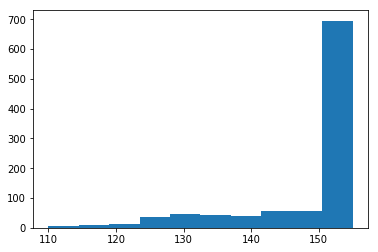

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
agent_wealth = [a.wealth for a in model.schedule.agents if a.unique_id >= N_passenger]
plt.hist(agent_wealth)



(array([    0.,     0.,     0.,     0.,     0.,  1000.,     0.,     0.,
            0.,     0.]),
 array([ 8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5]),
 <a list of 10 Patch objects>)

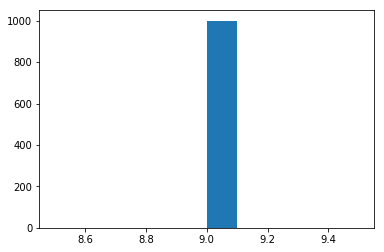

In [151]:
agent_jobs_time = [a.jobs_time for a in model.schedule.agents if a.unique_id >= N_passenger]
plt.hist(agent_jobs_time)

(array([  2.46100000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.80000000e+01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

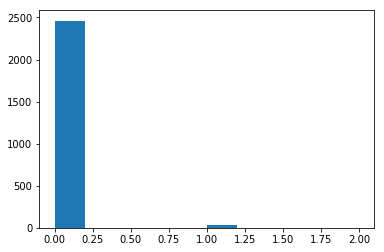

In [152]:
agent_jobs_time = [a.journeys_time for a in model.schedule.agents if a.unique_id <= N_passenger/2]
plt.hist(agent_jobs_time)

(array([ 461.,  118.,   51.,   56.,  939.,  708.,   40.,   31.,   47.,   49.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

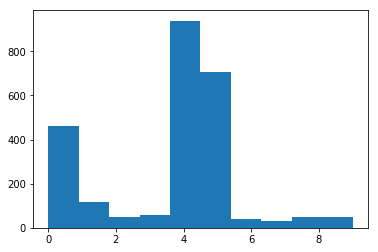

In [153]:
agent_jobs_time = [a.journeys_time for a in model.schedule.agents if a.unique_id >= N_passenger/2 and a.unique_id < N_passenger]
plt.hist(agent_jobs_time)

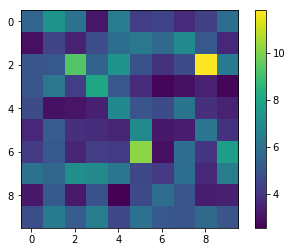

In [154]:
ratio_counts = np.zeros((model.grid.width,model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    driver_count = len([a for a in cell_content if a.unique_id >= N_passenger])
    passenger_count = len([a for a in cell_content if a.unique_id <= N_passenger])
    ratio_counts[x][y] = (passenger_count+1)/(driver_count+1)  #avoid division by 0
plt.imshow(ratio_counts, interpolation='nearest')
plt.colorbar()